In [1]:
import torch

In [12]:
import src.conv_onet.models.decoder as decoder
from torchsummary import summary

nn = decoder.NICE(coarse=True).to("cuda:0")

print(summary(decoder.MLP_no_xyz()))

Layer (type:depth-idx)                   Param #
├─ModuleList: 1-1                        --
|    └─DenseLayer: 2-1                   65,792
|    └─DenseLayer: 2-2                   65,792
|    └─DenseLayer: 2-3                   65,792
|    └─DenseLayer: 2-4                   98,560
|    └─DenseLayer: 2-5                   65,792
├─DenseLayer: 1-2                        257
Total params: 361,985
Trainable params: 361,985
Non-trainable params: 0
Layer (type:depth-idx)                   Param #
├─ModuleList: 1-1                        --
|    └─DenseLayer: 2-1                   65,792
|    └─DenseLayer: 2-2                   65,792
|    └─DenseLayer: 2-3                   65,792
|    └─DenseLayer: 2-4                   98,560
|    └─DenseLayer: 2-5                   65,792
├─DenseLayer: 1-2                        257
Total params: 361,985
Trainable params: 361,985
Non-trainable params: 0


In [4]:
import src.config as config

cfg = config.load_config("./configs/Replica/room0.yaml", "./configs/nice_slam.yaml")

In [8]:
import numpy as np

def load_pretrain(nice: decoder.NICE, cfg: dict):
    ckpt = torch.load(cfg['pretrained_decoders']['coarse'], map_location=cfg['mapping']['device'])
    coarse_dict = {}
    for key, val in ckpt['model'].items():
        if ('decoder' in key) and ('encoder' not in key):
            key = key[8:]
            coarse_dict[key] = val
    nice.coarse_decoder.load_state_dict(coarse_dict)

    ckpt = torch.load(cfg['pretrained_decoders']['middle_fine'], map_location=cfg['mapping']['device'])
    middle_dict = {}
    fine_dict = {}
    for key, val in ckpt['model'].items():
        if ('decoder' in key) and ('encoder' not in key):
            if 'coarse' in key:
                key = key[8+7:]
                middle_dict[key] = val
            elif 'fine' in key:
                key = key[8+5:]
                fine_dict[key] = val
    nice.middle_decoder.load_state_dict(middle_dict)
    nice.fine_decoder.load_state_dict(fine_dict)

    scale = cfg['scale']

    bound = torch.from_numpy(np.array(cfg['mapping']['bound'])*scale)
    bound_divisible = cfg['grid_len']['bound_divisible']
    bound[:, 1] = (((bound[:, 1]-bound[:, 0]) /
        bound_divisible).int()+1)*bound_divisible+bound[:, 0]

    nice.bound = bound
    nice.middle_decoder.bound = bound
    nice.fine_decoder.bound = bound
    nice.color_decoder.bound = bound
    nice.coarse_decoder.bound = bound * cfg['model']['coarse_bound_enlarge']

In [9]:
load_pretrain(nn, cfg)

In [10]:
import os

stages = ["coarse", "middle", "fine", "color"]

for stage in stages:
    for pt in os.listdir(f"./saved_inputs/{stage}")[:10]:
        data = torch.load(f"./saved_inputs/{stage}/{pt}")
        pi = data['pi'].to(cfg['mapping']['device'])
        c = data['c']
        print(nn(pi, c_grid=c, stage=stage).shape)

torch.Size([32000, 4])
torch.Size([32000, 4])
torch.Size([32000, 4])
torch.Size([32000, 4])
torch.Size([32000, 4])
torch.Size([32000, 4])
torch.Size([32000, 4])
torch.Size([32000, 4])
torch.Size([32000, 4])
torch.Size([32000, 4])
torch.Size([47952, 4])
torch.Size([47952, 4])
torch.Size([48000, 4])
torch.Size([48000, 4])
torch.Size([48000, 4])
torch.Size([48000, 4])
torch.Size([47952, 4])
torch.Size([48000, 4])
torch.Size([48000, 4])
torch.Size([48000, 4])
torch.Size([48000, 4])
torch.Size([48000, 4])
torch.Size([48000, 4])
torch.Size([48000, 4])
torch.Size([48000, 4])
torch.Size([47952, 4])
torch.Size([48000, 4])
torch.Size([48000, 4])
torch.Size([48000, 4])
torch.Size([48000, 4])
torch.Size([48000, 4])
torch.Size([48000, 4])
torch.Size([48000, 4])
torch.Size([9600, 4])
torch.Size([48000, 4])
torch.Size([9600, 4])
torch.Size([48000, 4])
torch.Size([9600, 4])
torch.Size([48000, 4])
torch.Size([9600, 4])


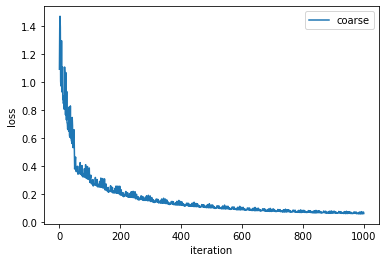

In [19]:
import pickle

with open("loss_record.pkl", "rb") as f:
    loss_record = pickle.load(f)

import matplotlib.pyplot as plt

# Use log-scale to show the loss

# plt.plot(loss_record['coarse'])
# plt.plot(loss_record['middle'])
# plt.plot(loss_record['fine'])
plt.plot(loss_record['color'])
# plt.yscale('log') 

plt.legend(['coarse', 'middle', 'fine', 'color'])
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()
